# Numpy and Pandas Usage and Performance Study

##### Copyright 2021 Qiyang Hu

In [37]:
#@title Licensed under MIT License (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://huqy.github.io/HighPerfDataSciPython/LICENSE.md
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## np.vectorize vs df.apply

In [2]:
def divide(a, b):
    if b == 0:
        return 0.0
    return float(a)/b

In [3]:
for N in [1000, 10000, 100000, 1000000, 10000000]:    

    print('')
    A_list = np.random.randint(1, 100, N)
    B_list = np.random.randint(1, 100, N)
    df = pd.DataFrame({'A': A_list, 'B': B_list})

    start_epoch_sec = int(time.time())
    df['result'] = df.apply(lambda row: divide(row['A'], row['B']), axis=1)
    end_epoch_sec = int(time.time())
    result_apply = end_epoch_sec - start_epoch_sec

    start_epoch_sec = int(time.time())
    df['result2'] = np.vectorize(divide)(df['A'], df['B'])
    end_epoch_sec = int(time.time())
    result_vectorize = end_epoch_sec - start_epoch_sec


    print('N=%d, df.apply: %d sec, np.vectorize: %d sec' % \
            (N, result_apply, result_vectorize) )

    # Make sure results from df.apply and np.vectorize match.
    assert(df['result'].equals(df['result2']))


N=1000, df.apply: 0 sec, np.vectorize: 0 sec

N=10000, df.apply: 0 sec, np.vectorize: 0 sec

N=100000, df.apply: 2 sec, np.vectorize: 0 sec

N=1000000, df.apply: 17 sec, np.vectorize: 0 sec

N=10000000, df.apply: 167 sec, np.vectorize: 3 sec


## Reducing Pandas Dataframe Memory Usage

### Data for 130-year MLB game logs

Data is originally sourced from [Retrosheet](https://www.retrosheet.org/gamelogs/index.html). All 127 CSV files can be combined using [csvkit](https://csvkit.readthedocs.io/en/1.0.2/) according to the [post](https://www.dataquest.io/blog/pandas-big-data/).

In [11]:
gl = pd.read_csv('https://query.data.world/s/xv7qk4qxizgi7ojdbq2hjvxzwsa2u6')
gl.head()

,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,h_score,length_outs,day_night,completion,forefeit,protest,park_id,attendance,length_minutes,v_line_score,h_line_score,v_at_bats,v_hits,v_doubles,v_triples,v_homeruns,v_rbi,v_sacrifice_hits,v_sacrifice_flies,v_hit_by_pitch,v_walks,v_intentional walks,v_strikeouts,v_stolen_bases,v_caught_stealing,v_grounded_into_double,v_first_catcher_interference,v_left_on_base,v_pitchers_used,v_individual_earned_runs,...,v_player_6_name,v_player_6_def_pos,v_player_7_id,v_player_7_name,v_player_7_def_pos,v_player_8_id,v_player_8_name,v_player_8_def_pos,v_player_9_id,v_player_9_name,v_player_9_def_pos,h_player_1_id,h_player_1_name,h_player_1_def_pos,h_player_2_id,h_player_2_name,h_player_2_def_pos,h_player_3_id,h_player_3_name,h_player_3_def_pos,h_player_4_id,h_player_4_name,h_player_4_def_pos,h_player_5_id,h_player_5_name,h_player_5_def_pos,h_player_6_id,h_player_6_name,h_player_6_def_pos,h_player_7_id,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
0,18710504,0,Thu,CL1,na,1,FW1,na,1,0,2,54.0,D,NaN,NaN,NaN,FOR01,200.0,120.0,000000000,010010000,30.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,6.0,1.0,-1.0,-1.0,-1.0,4.0,1.0,1.0,...,Al Pratt,1.0,sutte101,Ezra Sutton,5.0,carlj102,Jim Carleton,3.0,bassj101,John Bass,6.0,selmf101,Frank Sellman,5.0,mathb101,Bobby Mathews,1.0,foraj101,Jim Foran,3.0,goldw101,Wally Goldsmith,6.0,lennb101,Bill Lennon,2.0,caret101,Tom Carey,4.0,mince101,Ed Mincher,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,NaN,Y
1,18710505,0,Fri,BS1,na,1,WS3,na,1,20,18,54.0,D,NaN,NaN,NaN,WAS01,5000.0,145.0,107000435,640113030,41.0,13.0,1.0,2.0,0.0,13.0,0.0,0.0,0.0,18.0,-1.0,5.0,3.0,-1.0,-1.0,-1.0,12.0,1.0,6.0,...,Charlie Gould,3.0,schah101,Harry Schafer,5.0,conef101,Fred Cone,7.0,spala101,Al Spalding,1.0,watef102,Fred Waterman,5.0,forcd101,Davy Force,6.0,mille105,Everett Mills,3.0,allid101,Doug Allison,2.0,hallg101,George Hall,7.0,leona101,Andy Leonard,4.0,braia102,Asa Brainard,1.0,burrh101,Henry Burroughs,9.0,berth101,Henry Berthrong,8.0,HTBF,Y
2,18710506,0,Sat,CL1,na,2,RC1,na,1,12,4,54.0,D,NaN,NaN,NaN,RCK01,1000.0,140.0,610020003,010020100,49.0,11.0,1.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,10.0,1.0,0.0,...,Al Pratt,1.0,sutte101,Ezra Sutton,5.0,carlj102,Jim Carleton,3.0,bassj101,John Bass,6.0,mackd101,Denny Mack,3.0,addyb101,Bob Addy,4.0,fishc102,Cherokee Fisher,1.0,hasts101,Scott Hastings,8.0,ham-r101,Ralph Ham,5.0,ansoc101,Cap Anson,2.0,sagep101,Pony Sager,6.0,birdg101,George Bird,7.0,stirg101,Gat Stires,9.0,NaN,Y
3,18710508,0,Mon,CL1,na,3,CH1,na,1,12,14,54.0,D,NaN,NaN,NaN,CHI01,5000.0,150.0,101403111,077000000,46.0,15.0,2.0,1.0,2.0,10.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,7.0,1.0,6.0,...,Al Pratt,1.0,sutte101,Ezra Sutton,5.0,carlj102,Jim Carleton,3.0,bassj101,John Bass,6.0,mcatb101,Bub McAtee,3.0,kingm101,Marshall King,8.0,hodec101,Charlie Hodes,2.0,woodj106,Jimmy Wood,4.0,simmj101,Joe Simmons,9.0,folet101,Tom Foley,7.0,duffe101,Ed Duffy,6.0,pinke101,Ed Pinkham,5.0,zettg101,George Zettlein,1.0,NaN,Y
4,18710509,0,Tue,BS1,na,2,TRO,na,1,9,5,54.0,D,NaN,NaN,NaN,TRO01,3250.0,145.0,000002232,101003000,46.0,17.0,4.0,1.0,0.0,6.0,0.0,0.0,0.0,2.0,-1.0,0.0,1.0,-1.0,-1.0,-1.0,12.0,1.0,2.0,...,Charlie Gould,3.0,schah101,Harry Schafer,5.0,conef101,Fred Cone,7.0,spala101,Al Spalding,1.0,flync101,Clipper Flynn,9.0,mcgem101,Mike McGeary,2.0,yorkt101,Tom York,8.0,mcmuj101,John McMullin,1.0,kings101,Steve King,7.0,beave101,Edward Beavens,4.0,bells101,Steve Bellan,5.0,pikel101,Lip Pike,3.0,cravb101,Bill Craver,6.0,HTBF,Y


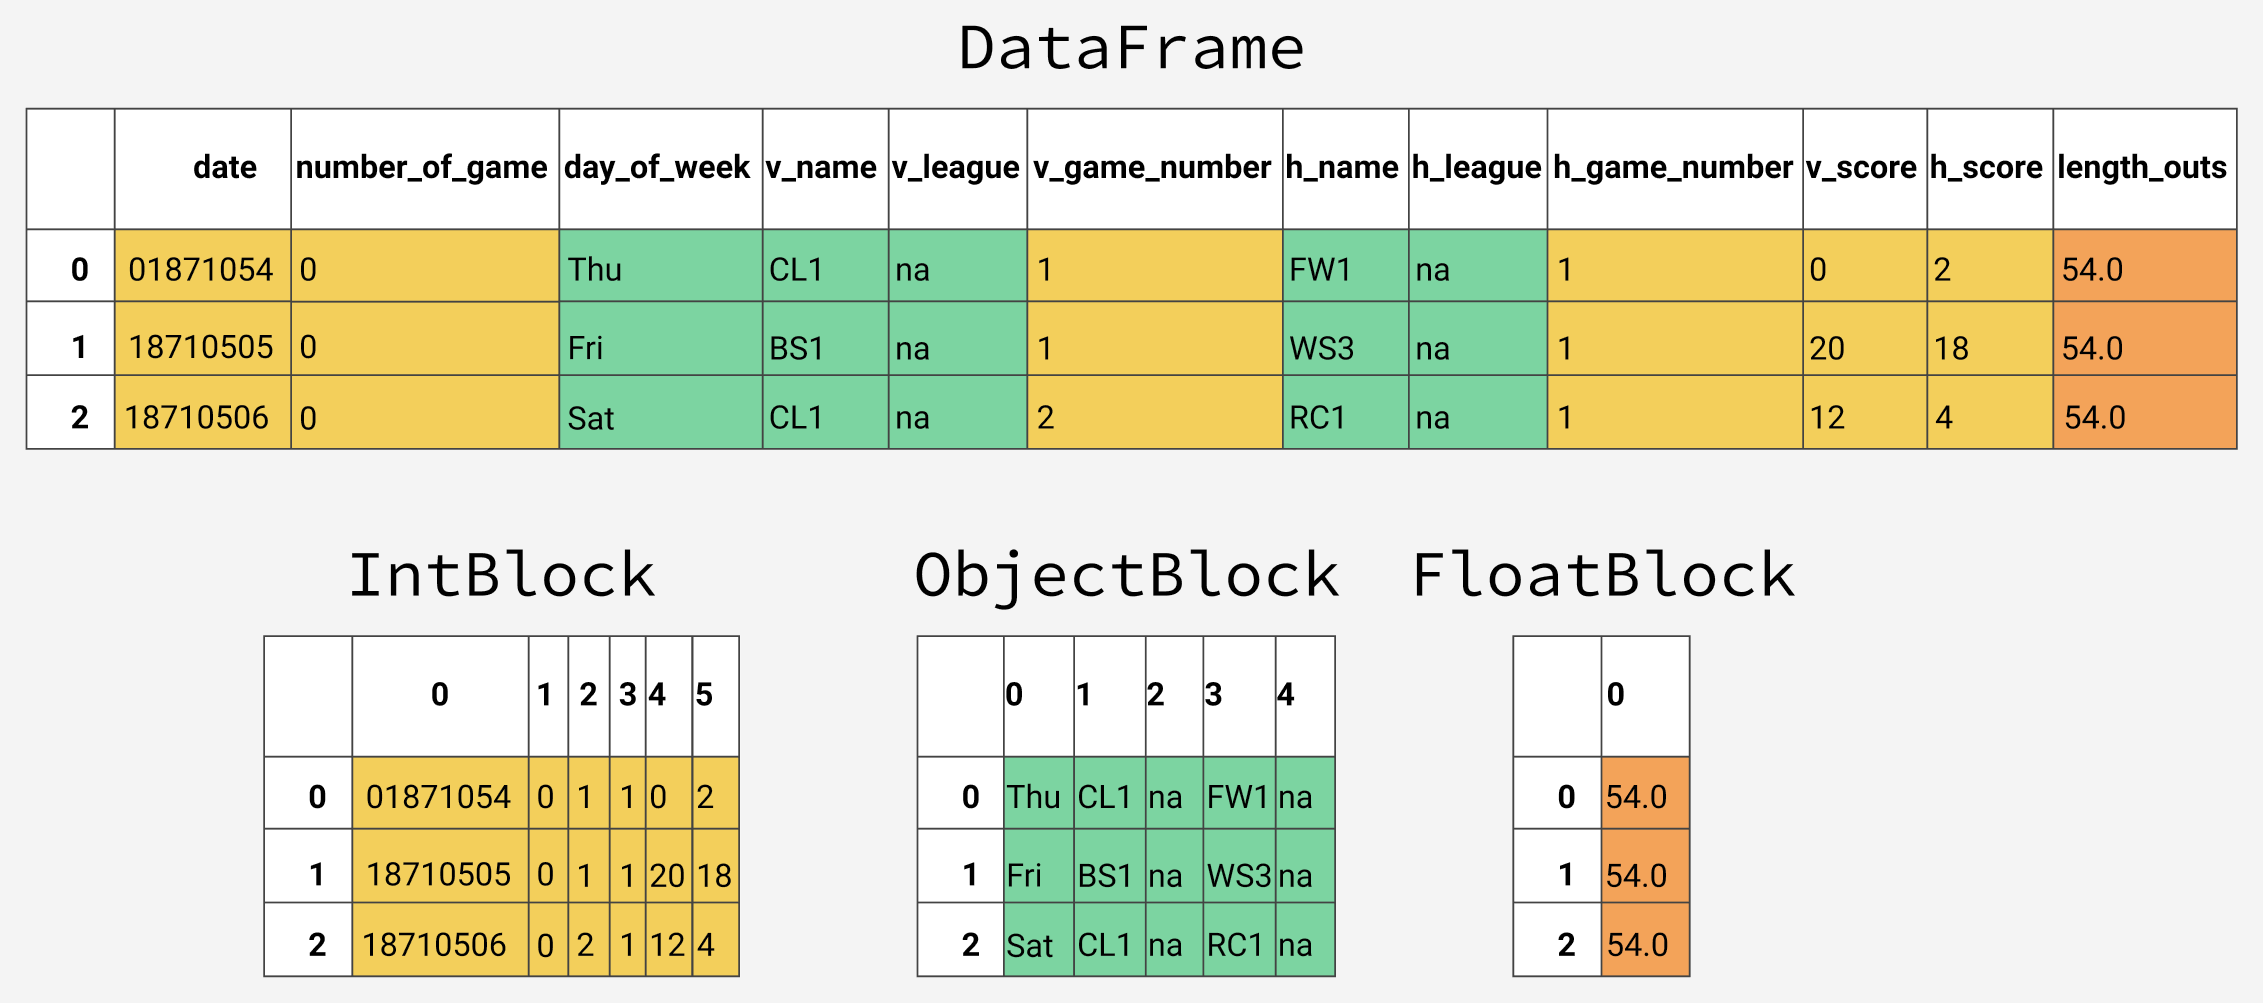

By default, pandas approximates of the memory usage of the dataframe to save time. We’ll set the memory_usage parameter to `deep` to get an accurate number.

In [12]:
gl.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171907 entries, 0 to 171906
Columns: 161 entries, date to acquisition_info
dtypes: float64(77), int64(6), object(78)
memory usage: 859.4 MB


In [13]:
for dtype in ['float','int','object']:
    selected_dtype = gl.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float columns: 1.29 MB
Average memory usage for int columns: 1.12 MB
Average memory usage for object columns: 9.50 MB


In [14]:
import numpy as np
int_types = ["uint8", "int8", "int16"]
for it in int_types:
    print(np.iinfo(it))

Machine parameters for uint8
---------------------------------------------------------------
min = 0
max = 255
---------------------------------------------------------------

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------



### Manually optimization from a [post](https://www.dataquest.io/blog/pandas-big-data/)

In [15]:
# We're going to be calculating memory usage a lot,
# so we'll create a function to save us some time!
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)
gl_int = gl.select_dtypes(include=['int'])
converted_int = gl_int.apply(pd.to_numeric,downcast='unsigned')
print(mem_usage(gl_int))
print(mem_usage(converted_int))
compare_ints = pd.concat([gl_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

7.87 MB
1.48 MB


,before,after
uint8,NaN,5.0
uint32,NaN,1.0
int64,6.0,NaN


In [16]:
gl_float = gl.select_dtypes(include=['float'])
converted_float = gl_float.apply(pd.to_numeric,downcast='float')
print(mem_usage(gl_float))
print(mem_usage(converted_float))
compare_floats = pd.concat([gl_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

100.99 MB
50.49 MB


,before,after
float32,NaN,77.0
float64,77.0,NaN


In [17]:
optimized_gl = gl.copy()
optimized_gl[converted_int.columns] = converted_int
optimized_gl[converted_float.columns] = converted_float
print(mem_usage(gl))
print(mem_usage(optimized_gl))

859.43 MB
802.54 MB


In [18]:
from sys import getsizeof
s1 = 'working out'
s2 = 'memory usage for'
s3 = 'strings in python is fun!'
s4 = 'strings in python is fun!'
for s in [s1, s2, s3, s4]:
    print(getsizeof(s))

60
65
74
74


In [19]:
obj_series = pd.Series(['working out',
    'memory usage for',
    'strings in python is fun!',
    'strings in python is fun!'])
obj_series.apply(getsizeof)

0    60
1    65
2    74
3    74
dtype: int64

In [20]:
gl_obj = gl.select_dtypes(include=['object']).copy()
gl_obj.describe()

,day_of_week,v_name,v_league,h_name,h_league,day_night,completion,forefeit,protest,park_id,v_line_score,h_line_score,hp_umpire_id,hp_umpire_name,1b_umpire_id,1b_umpire_name,2b_umpire_id,2b_umpire_name,3b_umpire_id,3b_umpire_name,lf_umpire_id,lf_umpire_name,rf_umpire_id,rf_umpire_name,v_manager_id,v_manager_name,h_manager_id,h_manager_name,winning_pitcher_id,winning_pitcher_name,losing_pitcher_id,losing_pitcher_name,saving_pitcher_id,saving_pitcher_name,winning_rbi_batter_id,winning_rbi_batter_id_name,v_starting_pitcher_id,v_starting_pitcher_name,h_starting_pitcher_id,h_starting_pitcher_name,v_player_1_id,v_player_1_name,v_player_2_id,v_player_2_name,v_player_3_id,v_player_3_name,v_player_4_id,v_player_4_name,v_player_5_id,v_player_5_name,v_player_6_id,v_player_6_name,v_player_7_id,v_player_7_name,v_player_8_id,v_player_8_name,v_player_9_id,v_player_9_name,h_player_1_id,h_player_1_name,h_player_2_id,h_player_2_name,h_player_3_id,h_player_3_name,h_player_4_id,h_player_4_name,h_player_5_id,h_player_5_name,h_player_6_id,h_player_6_name,h_player_7_id,h_player_7_name,h_player_8_id,h_player_8_name,h_player_9_id,h_player_9_name,additional_info,acquisition_info
count,171907,171907,171907,171907,171907,140150,116,145,180,171907,147271,147271,171888,171891,147040,171891,88540,171127,116723,171135,203,171902,9,171902,171907,171907,171907,171907,140229,140229,140229,140229,48018,140838,105699,140838,171863,171863,171863,171863,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140835,140835,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,140838,1456,140841
unique,7,148,7,148,7,2,116,3,5,245,36367,37859,1149,1146,678,678,324,325,362,363,31,32,8,9,648,648,659,659,5123,5084,5653,5606,3133,3117,5739,5674,5193,5129,5170,5125,2870,2847,3709,3673,2989,2964,2581,2563,3757,3722,4794,4736,5301,5241,4812,4763,5643,5585,2802,2782,3648,3614,2881,2858,2533,2517,3696,3660,4774,4720,5253,5197,4760,4710,5193,5142,332,1
top,Sat,CHN,NL,CHN,NL,D,"19580729,,4,3,45",H,V,STL07,000000000,000000000,klemb901,Bill Klem,connt901,(none),westj901,(none),mcgob901,(none),sudoe901,(none),gormt101,(none),mackc101,Connie Mack,mackc101,Connie Mack,johnw102,Walter Johnson,rixee101,Dutch Leonard,rivem002,(none),pujoa001,(none),younc102,Young,younc102,Young,suzui001,Ichiro Suzuki,fox-n101,Nellie Fox,speat101,Tris Speaker,bottj101,Jim Bottomley,heilh101,Harry Heilmann,grimc101,Charlie Grimm,grimc101,Charlie Grimm,lopea102,Al Lopez,grifa001,Alfredo Griffin,suzui001,Ichiro Suzuki,fox-n101,Nellie Fox,speat101,Tris Speaker,gehrl101,Lou Gehrig,heilh101,Harry Heilmann,grimc101,Charlie Grimm,grimc101,Charlie Grimm,lopea102,Al Lopez,spahw101,Warren Spahn,HTBF,Y
freq,28891,8870,88866,9024,88867,82724,1,69,90,7022,10102,8028,3545,3545,2029,24851,815,82587,1129,54412,30,171699,2,171893,3901,3901,3848,3848,385,385,251,295,523,92820,288,35139,403,441,412,451,893,893,852,852,1224,1224,816,816,663,663,465,465,485,485,687,687,333,333,927,927,859,859,1165,1165,752,752,612,612,427,427,491,491,676,676,339,339,1112,140841


In [21]:
dow = gl_obj.day_of_week
print(dow.head())
dow_cat = dow.astype('category')
print(dow_cat.head())

0    Thu
1    Fri
2    Sat
3    Mon
4    Tue
Name: day_of_week, dtype: object
0    Thu
1    Fri
2    Sat
3    Mon
4    Tue
Name: day_of_week, dtype: category
Categories (7, object): ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']


In [22]:
dow_cat.head().cat.codes

0    4
1    0
2    2
3    1
4    5
dtype: int8

In [23]:
print(mem_usage(dow))
print(mem_usage(dow_cat))

9.84 MB
0.16 MB


In [24]:
converted_obj = pd.DataFrame()
for col in gl_obj.columns:
    num_unique_values = len(gl_obj[col].unique())
    num_total_values = len(gl_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = gl_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = gl_obj[col]

In [25]:
print(mem_usage(gl_obj))
print(mem_usage(converted_obj))
compare_obj = pd.concat([gl_obj.dtypes,converted_obj.dtypes],axis=1)
compare_obj.columns = ['before','after']
compare_obj.apply(pd.Series.value_counts)

750.57 MB
51.67 MB


,before,after
object,78.0,NaN
category,NaN,2.0
category,NaN,1.0
category,NaN,1.0
category,NaN,1.0
...,...,...
category,NaN,1.0
category,NaN,1.0
category,NaN,1.0
category,NaN,1.0


In [26]:
optimized_gl[converted_obj.columns] = converted_obj
mem_usage(optimized_gl)

'103.64 MB'

In [ ]:
date = optimized_gl.date
print(mem_usage(date))
date.head()

0.66 MB


0    18710504
1    18710505
2    18710506
3    18710508
4    18710509
Name: date, dtype: uint32

In [ ]:
optimized_gl['date'] = pd.to_datetime(date,format='%Y%m%d')
print(mem_usage(optimized_gl))
optimized_gl.date.head()

104.29 MB


0   1871-05-04
1   1871-05-05
2   1871-05-06
3   1871-05-08
4   1871-05-09
Name: date, dtype: datetime64[ns]

In [ ]:
dtypes = optimized_gl.drop('date',axis=1).dtypes
dtypes_col = dtypes.index
dtypes_type = [i.name for i in dtypes.values]
column_types = dict(zip(dtypes_col, dtypes_type))
# rather than print all 161 items, we'll
# sample 10 key/value pairs from the dict
# and print it nicely using prettyprint
preview = first2pairs = {key:value for key,value in list(column_types.items())[:10]}
import pprint
pp = pp = pprint.PrettyPrinter(indent=4)
pp.pprint(preview)

{   'day_of_week': 'category',
    'h_game_number': 'uint8',
    'h_league': 'category',
    'h_name': 'category',
    'h_score': 'uint8',
    'number_of_game': 'uint8',
    'v_game_number': 'uint8',
    'v_league': 'category',
    'v_name': 'category',
    'v_score': 'uint8'}


In [ ]:
read_and_optimized = pd.read_csv('https://query.data.world/s/xv7qk4qxizgi7ojdbq2hjvxzwsa2u6',dtype=column_types,parse_dates=['date'],infer_datetime_format=True)
print(mem_usage(read_and_optimized))
read_and_optimized.head()

104.28 MB


,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,h_score,length_outs,day_night,completion,forefeit,protest,park_id,attendance,length_minutes,v_line_score,h_line_score,v_at_bats,v_hits,v_doubles,v_triples,v_homeruns,v_rbi,v_sacrifice_hits,v_sacrifice_flies,v_hit_by_pitch,v_walks,v_intentional walks,v_strikeouts,v_stolen_bases,v_caught_stealing,v_grounded_into_double,v_first_catcher_interference,v_left_on_base,v_pitchers_used,v_individual_earned_runs,...,v_player_6_name,v_player_6_def_pos,v_player_7_id,v_player_7_name,v_player_7_def_pos,v_player_8_id,v_player_8_name,v_player_8_def_pos,v_player_9_id,v_player_9_name,v_player_9_def_pos,h_player_1_id,h_player_1_name,h_player_1_def_pos,h_player_2_id,h_player_2_name,h_player_2_def_pos,h_player_3_id,h_player_3_name,h_player_3_def_pos,h_player_4_id,h_player_4_name,h_player_4_def_pos,h_player_5_id,h_player_5_name,h_player_5_def_pos,h_player_6_id,h_player_6_name,h_player_6_def_pos,h_player_7_id,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
0,1871-05-04,0,Thu,CL1,na,1,FW1,na,1,0,2,54.0,D,NaN,NaN,NaN,FOR01,200.0,120.0,000000000,010010000,30.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,6.0,1.0,-1.0,-1.0,-1.0,4.0,1.0,1.0,...,Al Pratt,1.0,sutte101,Ezra Sutton,5.0,carlj102,Jim Carleton,3.0,bassj101,John Bass,6.0,selmf101,Frank Sellman,5.0,mathb101,Bobby Mathews,1.0,foraj101,Jim Foran,3.0,goldw101,Wally Goldsmith,6.0,lennb101,Bill Lennon,2.0,caret101,Tom Carey,4.0,mince101,Ed Mincher,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,NaN,Y
1,1871-05-05,0,Fri,BS1,na,1,WS3,na,1,20,18,54.0,D,NaN,NaN,NaN,WAS01,5000.0,145.0,107000435,640113030,41.0,13.0,1.0,2.0,0.0,13.0,0.0,0.0,0.0,18.0,-1.0,5.0,3.0,-1.0,-1.0,-1.0,12.0,1.0,6.0,...,Charlie Gould,3.0,schah101,Harry Schafer,5.0,conef101,Fred Cone,7.0,spala101,Al Spalding,1.0,watef102,Fred Waterman,5.0,forcd101,Davy Force,6.0,mille105,Everett Mills,3.0,allid101,Doug Allison,2.0,hallg101,George Hall,7.0,leona101,Andy Leonard,4.0,braia102,Asa Brainard,1.0,burrh101,Henry Burroughs,9.0,berth101,Henry Berthrong,8.0,HTBF,Y
2,1871-05-06,0,Sat,CL1,na,2,RC1,na,1,12,4,54.0,D,NaN,NaN,NaN,RCK01,1000.0,140.0,610020003,010020100,49.0,11.0,1.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,10.0,1.0,0.0,...,Al Pratt,1.0,sutte101,Ezra Sutton,5.0,carlj102,Jim Carleton,3.0,bassj101,John Bass,6.0,mackd101,Denny Mack,3.0,addyb101,Bob Addy,4.0,fishc102,Cherokee Fisher,1.0,hasts101,Scott Hastings,8.0,ham-r101,Ralph Ham,5.0,ansoc101,Cap Anson,2.0,sagep101,Pony Sager,6.0,birdg101,George Bird,7.0,stirg101,Gat Stires,9.0,NaN,Y
3,1871-05-08,0,Mon,CL1,na,3,CH1,na,1,12,14,54.0,D,NaN,NaN,NaN,CHI01,5000.0,150.0,101403111,077000000,46.0,15.0,2.0,1.0,2.0,10.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,7.0,1.0,6.0,...,Al Pratt,1.0,sutte101,Ezra Sutton,5.0,carlj102,Jim Carleton,3.0,bassj101,John Bass,6.0,mcatb101,Bub McAtee,3.0,kingm101,Marshall King,8.0,hodec101,Charlie Hodes,2.0,woodj106,Jimmy Wood,4.0,simmj101,Joe Simmons,9.0,folet101,Tom Foley,7.0,duffe101,Ed Duffy,6.0,pinke101,Ed Pinkham,5.0,zettg101,George Zettlein,1.0,NaN,Y
4,1871-05-09,0,Tue,BS1,na,2,TRO,na,1,9,5,54.0,D,NaN,NaN,NaN,TRO01,3250.0,145.0,000002232,101003000,46.0,17.0,4.0,1.0,0.0,6.0,0.0,0.0,0.0,2.0,-1.0,0.0,1.0,-1.0,-1.0,-1.0,12.0,1.0,2.0,...,Charlie Gould,3.0,schah101,Harry Schafer,5.0,conef101,Fred Cone,7.0,spala101,Al Spalding,1.0,flync101,Clipper Flynn,9.0,mcgem101,Mike McGeary,2.0,yorkt101,Tom York,8.0,mcmuj101,John McMullin,1.0,kings101,Steve King,7.0,beave101,Edward Beavens,4.0,bells101,Steve Bellan,5.0,pikel101,Lip Pike,3.0,cravb101,Bill Craver,6.0,HTBF,Y


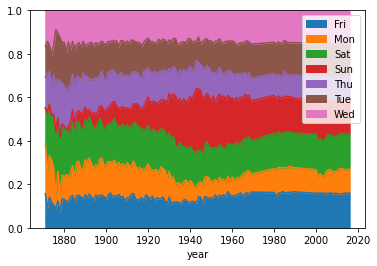

In [ ]:
optimized_gl['year'] = optimized_gl.date.dt.year
games_per_day = optimized_gl.pivot_table(index='year',columns='day_of_week',values='date',aggfunc=len)
games_per_day = games_per_day.divide(games_per_day.sum(axis=1),axis=0)
ax = games_per_day.plot(kind='area',stacked='true')
ax.legend(loc='upper right')
ax.set_ylim(0,1)
plt.show()

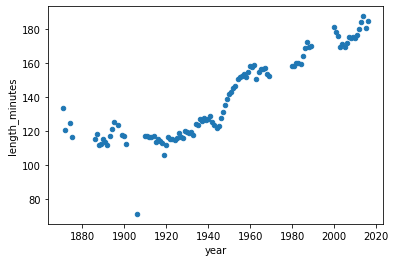

In [ ]:
game_lengths = optimized_gl.pivot_table(index='year', values='length_minutes')
game_lengths.reset_index().plot.scatter('year','length_minutes')
plt.show()

### Using dtype_diet

In [27]:
!pip install dtype_diet

In [34]:
gl.head()

,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,h_score,length_outs,day_night,completion,forefeit,protest,park_id,attendance,length_minutes,v_line_score,h_line_score,v_at_bats,v_hits,v_doubles,v_triples,v_homeruns,v_rbi,v_sacrifice_hits,v_sacrifice_flies,v_hit_by_pitch,v_walks,v_intentional walks,v_strikeouts,v_stolen_bases,v_caught_stealing,v_grounded_into_double,v_first_catcher_interference,v_left_on_base,v_pitchers_used,v_individual_earned_runs,...,v_player_6_name,v_player_6_def_pos,v_player_7_id,v_player_7_name,v_player_7_def_pos,v_player_8_id,v_player_8_name,v_player_8_def_pos,v_player_9_id,v_player_9_name,v_player_9_def_pos,h_player_1_id,h_player_1_name,h_player_1_def_pos,h_player_2_id,h_player_2_name,h_player_2_def_pos,h_player_3_id,h_player_3_name,h_player_3_def_pos,h_player_4_id,h_player_4_name,h_player_4_def_pos,h_player_5_id,h_player_5_name,h_player_5_def_pos,h_player_6_id,h_player_6_name,h_player_6_def_pos,h_player_7_id,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
0,18710504,0,Thu,CL1,na,1,FW1,na,1,0,2,54.0,D,NaN,NaN,NaN,FOR01,200.0,120.0,000000000,010010000,30.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,6.0,1.0,-1.0,-1.0,-1.0,4.0,1.0,1.0,...,Al Pratt,1.0,sutte101,Ezra Sutton,5.0,carlj102,Jim Carleton,3.0,bassj101,John Bass,6.0,selmf101,Frank Sellman,5.0,mathb101,Bobby Mathews,1.0,foraj101,Jim Foran,3.0,goldw101,Wally Goldsmith,6.0,lennb101,Bill Lennon,2.0,caret101,Tom Carey,4.0,mince101,Ed Mincher,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,NaN,Y
1,18710505,0,Fri,BS1,na,1,WS3,na,1,20,18,54.0,D,NaN,NaN,NaN,WAS01,5000.0,145.0,107000435,640113030,41.0,13.0,1.0,2.0,0.0,13.0,0.0,0.0,0.0,18.0,-1.0,5.0,3.0,-1.0,-1.0,-1.0,12.0,1.0,6.0,...,Charlie Gould,3.0,schah101,Harry Schafer,5.0,conef101,Fred Cone,7.0,spala101,Al Spalding,1.0,watef102,Fred Waterman,5.0,forcd101,Davy Force,6.0,mille105,Everett Mills,3.0,allid101,Doug Allison,2.0,hallg101,George Hall,7.0,leona101,Andy Leonard,4.0,braia102,Asa Brainard,1.0,burrh101,Henry Burroughs,9.0,berth101,Henry Berthrong,8.0,HTBF,Y
2,18710506,0,Sat,CL1,na,2,RC1,na,1,12,4,54.0,D,NaN,NaN,NaN,RCK01,1000.0,140.0,610020003,010020100,49.0,11.0,1.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,10.0,1.0,0.0,...,Al Pratt,1.0,sutte101,Ezra Sutton,5.0,carlj102,Jim Carleton,3.0,bassj101,John Bass,6.0,mackd101,Denny Mack,3.0,addyb101,Bob Addy,4.0,fishc102,Cherokee Fisher,1.0,hasts101,Scott Hastings,8.0,ham-r101,Ralph Ham,5.0,ansoc101,Cap Anson,2.0,sagep101,Pony Sager,6.0,birdg101,George Bird,7.0,stirg101,Gat Stires,9.0,NaN,Y
3,18710508,0,Mon,CL1,na,3,CH1,na,1,12,14,54.0,D,NaN,NaN,NaN,CHI01,5000.0,150.0,101403111,077000000,46.0,15.0,2.0,1.0,2.0,10.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,7.0,1.0,6.0,...,Al Pratt,1.0,sutte101,Ezra Sutton,5.0,carlj102,Jim Carleton,3.0,bassj101,John Bass,6.0,mcatb101,Bub McAtee,3.0,kingm101,Marshall King,8.0,hodec101,Charlie Hodes,2.0,woodj106,Jimmy Wood,4.0,simmj101,Joe Simmons,9.0,folet101,Tom Foley,7.0,duffe101,Ed Duffy,6.0,pinke101,Ed Pinkham,5.0,zettg101,George Zettlein,1.0,NaN,Y
4,18710509,0,Tue,BS1,na,2,TRO,na,1,9,5,54.0,D,NaN,NaN,NaN,TRO01,3250.0,145.0,000002232,101003000,46.0,17.0,4.0,1.0,0.0,6.0,0.0,0.0,0.0,2.0,-1.0,0.0,1.0,-1.0,-1.0,-1.0,12.0,1.0,2.0,...,Charlie Gould,3.0,schah101,Harry Schafer,5.0,conef101,Fred Cone,7.0,spala101,Al Spalding,1.0,flync101,Clipper Flynn,9.0,mcgem101,Mike McGeary,2.0,yorkt101,Tom York,8.0,mcmuj101,John McMullin,1.0,kings101,Steve King,7.0,beave101,Edward Beavens,4.0,bells101,Steve Bellan,5.0,pikel101,Lip Pike,3.0,cravb101,Bill Craver,6.0,HTBF,Y


In [35]:
gl.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171907 entries, 0 to 171906
Columns: 161 entries, date to acquisition_info
dtypes: float64(77), int64(6), object(78)
memory usage: 859.4 MB


In [32]:
import dtype_diet
res = dtype_diet.report_on_dataframe(gl)
res

,Current dtype,Proposed dtype,Current Memory (MB),Proposed Memory (MB),Ram Usage Improvement (MB),Ram Usage Improvement (%)
Column,,,,,,
date,int64,int32,671.574219,335.818359,335.755859,49.995347
number_of_game,int64,int8,671.574219,84.001465,587.572754,87.491857
day_of_week,object,category,5036.400391,84.362793,4952.037598,98.324939
v_name,object,category,5036.400391,174.776367,4861.624023,96.529736
v_league,object,category,4952.461426,84.359375,4868.102051,98.296617
...,...,...,...,...,...,...
h_player_9_id,object,category,4955.471680,412.757324,4542.714355,91.670675
h_player_9_name,object,category,5225.463379,421.197266,4804.266113,91.939523
h_player_9_def_pos,float64,float16,671.574219,167.940430,503.633789,74.993020


In [33]:
gl2 = gl.copy()
for index, row in res.iterrows():
    colname = index
    newdtype = row['Proposed dtype']
    gl2[colname] = gl2[colname].astype(newdtype)
gl2.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171907 entries, 0 to 171906
Columns: 161 entries, date to acquisition_info
dtypes: category(78), float16(76), float32(1), int16(2), int32(1), int8(3)
memory usage: 79.0 MB
